# Relax Inc. Take-Home Challenge

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
from scipy.stats import chi2_contingency
from scipy import stats
from sklearn import tree, metrics
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import mlxtend
from mlxtend.plotting import plot_confusion_matrix
from sklearn.tree import export_graphviz
import graphviz
import pydotplus
from io import StringIO  
from IPython.display import Image

goal: Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven-day  period, identify which factors predict future user adoption.

First, I have to determine who is an adopted user

A  usage  summary  table  ( "takehome_user_engagement" )  that  has  a  row  for  each  day
that  a  user  logged  into  the  product.

In [2]:
takehome_user_engagement = pd.read_csv("takehome_user_engagement.csv")

#there is only a value of 1 for the column visited, so I will remove because I will not need it
takehome_user_engagement = takehome_user_engagement.drop("visited", axis = 1)
takehome_user_engagement['time_stamp'] = pd.to_datetime(takehome_user_engagement['time_stamp'])
takehome_user_engagement['truncate_date'] = takehome_user_engagement['time_stamp'].dt.floor('d')

#add a count for every login
takehome_user_engagement['count'] = 1
takehome_user_engagement

,time_stamp,user_id,truncate_date,count
0,2014-04-22 03:53:30,1,2014-04-22,1
1,2013-11-15 03:45:04,2,2013-11-15,1
2,2013-11-29 03:45:04,2,2013-11-29,1
3,2013-12-09 03:45:04,2,2013-12-09,1
4,2013-12-25 03:45:04,2,2013-12-25,1
...,...,...,...,...
207912,2013-09-06 06:14:15,11996,2013-09-06,1
207913,2013-01-15 18:28:37,11997,2013-01-15,1
207914,2014-04-27 12:45:16,11998,2014-04-27,1
207915,2012-06-02 11:55:59,11999,2012-06-02,1


In [3]:
#Using this information I can make a list of members that can be considered 'adopted'. 
#I will do this using the time_stamp in takehome_user_engagement. 
#The code below selects the users that have logged into the product on three separate days for a 7-day time period.
#The users are collected in the "active_users" list

active_users =[]
user_ids = takehome_user_engagement.user_id.unique()
for user_id in user_ids:
    df = takehome_user_engagement[takehome_user_engagement['user_id'] == user_id]
    df = df.drop('time_stamp', axis=1)
    df = df.set_index('truncate_date')
    timestamp_range = pd.date_range(start=df.index.min(), end=df.index.max())
    new_df = pd.DataFrame(index=timestamp_range)
    new_df = new_df.join(df, on=new_df.index)
    new_df.user_id=new_df.user_id.fillna(user_id)
    new_df['count']=new_df['count'].fillna(0)
    new_df.user_id = new_df.user_id.astype('int')
    new_df['count'] = new_df['count'].astype('int')
    new_df['sum_over_7days'] = new_df['count'].rolling(window=7).sum()
    if (new_df['sum_over_7days'] > 2).any() == True:
        active_users.append(new_df[new_df.sum_over_7days > 2].user_id.unique()[0])

A  user  table  ( "takehome_users" )  with  data  on  12,000  users  who  signed  up  for  the product  in  the  last  two  years.   This  table  includes:
* name:  the  user's  name
* object_id:   the  user's  id
* email:  email  address
* creation_source:   how  their  account  was  created.  This  takes  on  one of  5  values:
  * PERSONAL_PROJECTS:  invited  to  join  another  user's personal  workspace
  * GUEST_INVITE:  invited  to  an  organization  as  a  guest (limited  permissions)
  * ORG_INVITE:  invited  to  an  organization  (as  a  full  member)
  * SIGNUP:  signed  up  via  the  website
  * SIGNUP_GOOGLE_AUTH:  signed  up  using  Google Authentication  (using  a  Google  email  account  for  their  login id)
* creation_time:  when  they  created  their  account
* last_session_creation_time:   unix  timestamp  of  last  login
* opted_in_to_mailing_list:  whether  they  have  opted  into  receiving marketing  emails
* enabled_for_marketing_drip:  whether  they  are  on  the  regular marketing  email  drip
* org_id:   the  organization  (group  of  users)  they  belong  to
* invited_by_user_id:   which  user  invited  them  to  join  (if  applicable).


In [4]:
takehome_users = pd.read_csv("takehome_users.csv", encoding='latin-1')
takehome_users.rename(columns={'object_id':"user_id"}, inplace = True)
takehome_users

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0
...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN


Here I will add a column for those users that are active

In [5]:
takehome_users['adopted'] = 0

In [6]:
for i, row in takehome_users.iterrows():
    if row['user_id'] in active_users:
        takehome_users.loc[takehome_users['user_id'] == i,'adopted'] = 1

In [7]:
takehome_users.adopted.unique()

array([1, 0], dtype=int64)

In [8]:
takehome_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   user_id                     12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
 10  adopted                     12000 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 1.0+ MB


Next I will go through each of the features and think about their importance

### invited_by_user_id

Here I will add a column that uses the invited_by_user_id column. The new column invited_by_user_adopted includes whether the user was invited by a member that is an adopted user.

In [9]:
takehome_users.invited_by_user_id = takehome_users.invited_by_user_id.fillna(-1)

In [10]:
takehome_users.invited_by_user_id = takehome_users.invited_by_user_id.astype('int')

In [11]:
takehome_users['invited_by_user_adopted'] = 0
for i, row in takehome_users.iterrows():
    if row['invited_by_user_id'] in active_users:
        takehome_users.loc[takehome_users['invited_by_user_id'] == i,'invited_by_user_adopted'] = 1

In [12]:
takehome_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   user_id                     12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          12000 non-null  int32  
 10  adopted                     12000 non-null  int64  
 11  invited_by_user_adopted     12000 non-null  int64  
dtypes: float64(1), int32(1), int64(6), object(4)
memory usage: 1.1+ MB


adopted                     0     1
invited_by_user_adopted            
0                        9890  1502
1                         513    95
The P-Value of the ChiSq Test is: 0.09595529139074223


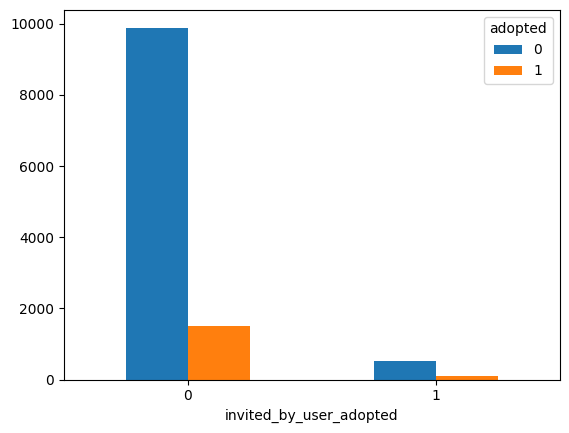

In [13]:
# Cross tabulation between opted_in_to_mailing_list and enabled_for_marketing_drip
CrosstabResult=pd.crosstab(index=takehome_users['invited_by_user_adopted'],
                           columns=takehome_users['adopted'])
print(CrosstabResult)
 
# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)
 
# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)
 
print('The P-Value of the ChiSq Test is:', ChiSqResult[1])
barplot = CrosstabResult.plot.bar(rot=0)

It looks like the invited_by_user_adopted is not correlated to whether the user is an adopted user, according to the chi-squared test. However, the p-value is quite low and close to 0.05

### creation_time

Perhaps the year, season, month, day of the week, and/or time of day matter for adoption. Maybe these time features are related to some other factors that can influence the user adoption, but are not included in the data we have right now. How were they incentivized to create the account at the time of creation? and is that related to a particular time of the year, maybe the seasons? For example, maybe this is a product that is mainly used during the summer. And people during the summer are looking for such a product. They find it, and create the account during the summer. So now we know that the more loyal users are those that use the product during the summer.

In [14]:
takehome_users['creation_time'] = pd.to_datetime(takehome_users['creation_time'])
takehome_users['creation_time_month_name'] = takehome_users.creation_time.dt.month_name()
takehome_users['creation_time_day'] = takehome_users.creation_time.dt.dayofweek
takehome_users['creation_time_dayofyear'] = takehome_users.creation_time.dt.dayofyear

In [15]:
takehome_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   float64       
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          12000 non-null  int32         
 10  adopted                     12000 non-null  int64         
 11  invited_by_user_adopted     12000 non-null  int64     

In [16]:
takehome_users

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,invited_by_user_adopted,creation_time_month_name,creation_time_day,creation_time_dayofyear
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803,1,0,April,1,112
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316,0,0,November,4,319
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525,0,0,March,1,78
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151,0,0,May,1,141
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240,0,0,January,3,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263,0,0,September,4,249
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,-1,0,0,January,3,10
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074,0,0,April,6,117
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,-1,0,0,May,3,152


In [17]:
def add_season(dayofyear):
    if dayofyear >=0 and dayofyear <=80:
        season = 'winter'
    if dayofyear > 80 and dayofyear <= 172:
        season = 'spring'
    if dayofyear > 172 and dayofyear <= 266:
        season = 'summer'
    if dayofyear > 266 and dayofyear <= 334:
        season = 'fall'
    if dayofyear > 334:
        season = 'winter'

    return season

def add_weekday_or_weekend(weekday_weekend):
    if weekday_weekend in [0,1,2,3,4]:
        season = 'weekday'
    if weekday_weekend in [5,6]:
        season = 'weekend'

    return season

takehome_users['creation_time_season'] = takehome_users['creation_time_dayofyear'].apply(add_season)
takehome_users['creation_time_dayofweek'] = takehome_users['creation_time_day'].apply(add_weekday_or_weekend)

In [18]:
takehome_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   float64       
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          12000 non-null  int32         
 10  adopted                     12000 non-null  int64         
 11  invited_by_user_adopted     12000 non-null  int64     

In [19]:
takehome_users = pd.get_dummies(takehome_users, columns=['creation_time_season'])

In [20]:
takehome_users

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,invited_by_user_adopted,creation_time_month_name,creation_time_day,creation_time_dayofyear,creation_time_dayofweek,creation_time_season_fall,creation_time_season_spring,creation_time_season_summer,creation_time_season_winter
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803,1,0,April,1,112,weekday,0,1,0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316,0,0,November,4,319,weekday,1,0,0,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525,0,0,March,1,78,weekday,0,0,0,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151,0,0,May,1,141,weekday,0,1,0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240,0,0,January,3,17,weekday,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263,0,0,September,4,249,weekday,0,0,1,0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,-1,0,0,January,3,10,weekday,0,0,0,1
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074,0,0,April,6,117,weekend,0,1,0,0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,-1,0,0,May,3,152,weekday,0,1,0,0


Here, I will focus on the season of the year when the creation of the account occurred that could be related to whether the user was adopted or not

adopted                         0     1
creation_time_season_summer            
0                            8109  1241
1                            2294   356
The P-Value of the ChiSq Test is: 0.8545601716416362
adopted                       0     1
creation_time_season_fall            
0                          8613  1329
1                          1790   268
The P-Value of the ChiSq Test is: 0.700994599294538
adopted                         0     1
creation_time_season_winter            
0                            7167  1122
1                            3236   475
The P-Value of the ChiSq Test is: 0.2853711402153868
adopted                         0     1
creation_time_season_spring            
0                            7320  1099
1                            3083   498
The P-Value of the ChiSq Test is: 0.21897033106950797


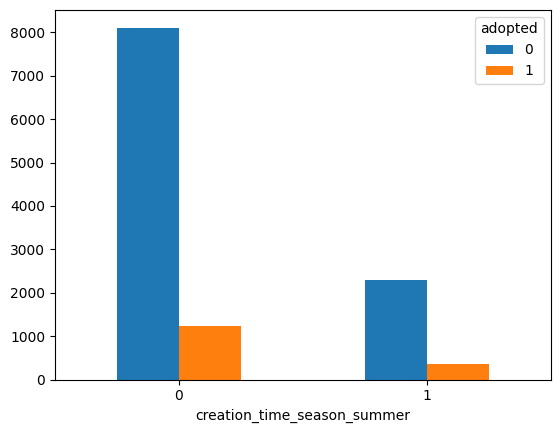

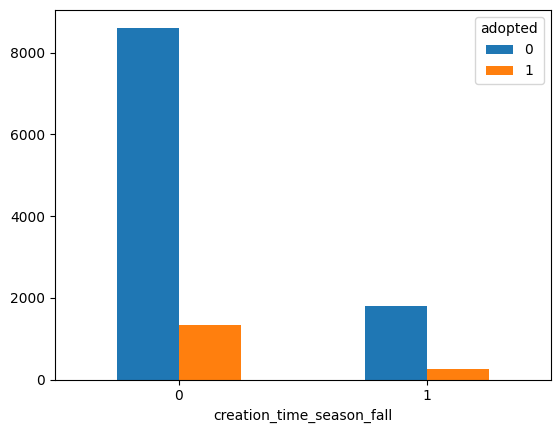

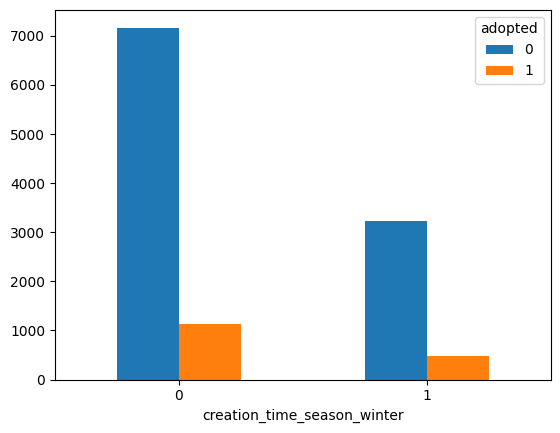

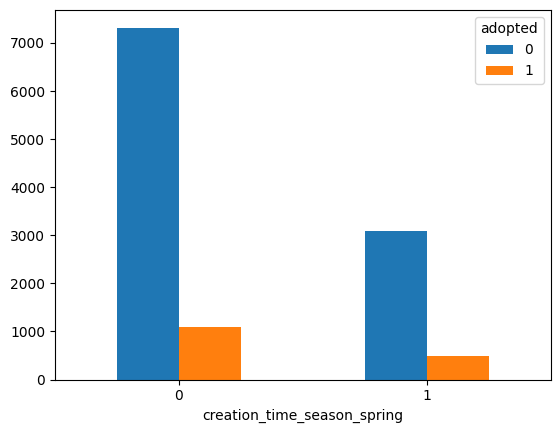

In [21]:
seasons = ['summer','fall','winter','spring']
# Cross tabulation between opted_in_to_mailing_list and enabled_for_marketing_drip
for season in seasons:
    CrosstabResult=pd.crosstab(index=takehome_users['creation_time_season_%s' %(season)],
                           columns=takehome_users['adopted'])
    print(CrosstabResult)
 
    # Performing Chi-sq test
    ChiSqResult = chi2_contingency(CrosstabResult)
 
    # P-Value is the Probability of H0 being True
    # If P-Value > 0.05 then only we Accept the assumption(H0)
 
    print('The P-Value of the ChiSq Test is:', ChiSqResult[1])
    barplot = CrosstabResult.plot.bar(rot=0)

It looks like the season is not correlated to whether the user is an adopted user, according to the chi-squared test.

### days_since_creation

Here I will carry out a statistical test to determine the correlation between the days since creation of the account and whether the user was adopted or not

In [22]:
takehome_users['days_since_creation'] = takehome_users['creation_time'] - takehome_users.creation_time.min()
takehome_users['days_since_creation'] = takehome_users['days_since_creation'].dt.days

Next, I will test for normality by first looking at the distribution, creating a Q-Q plot, and performing a Shapiro-Wilk test. 

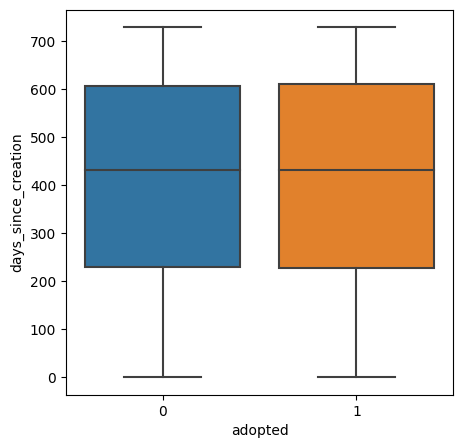

In [23]:
fig, ax = plt.subplots(1,1, figsize = (5,5))
sns.boxplot(data=takehome_users[['adopted','days_since_creation']].dropna(), x="adopted", y="days_since_creation");

Distribution of the days_since_creation feature for adopted users

<AxesSubplot: >

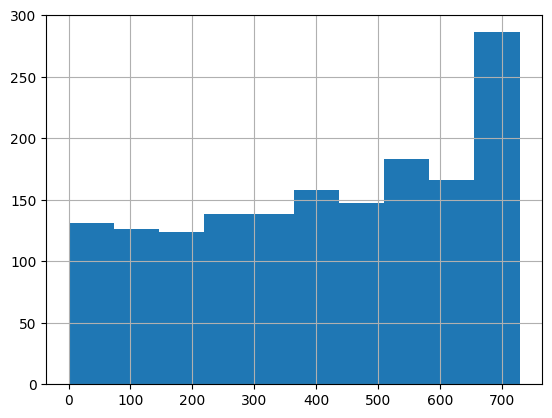

In [202]:
takehome_users[takehome_users['adopted'] == 1]['days_since_creation'].hist()

Distribution of the days_since_creation feature for not adopted users

<AxesSubplot: >

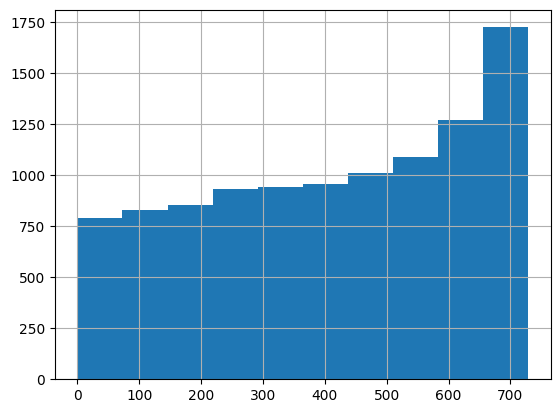

In [203]:
takehome_users[takehome_users['adopted'] == 0]['days_since_creation'].hist()

Q-Q plots indicate deviation from normality

((array([-3.33018813, -3.07477781, -2.93285045, ...,  2.93285045,
          3.07477781,  3.33018813]),
  array([  0,   0,   0, ..., 729, 729, 729], dtype=int64)),
 (211.76006376395182, 412.17532874139016, 0.9715962706639293))

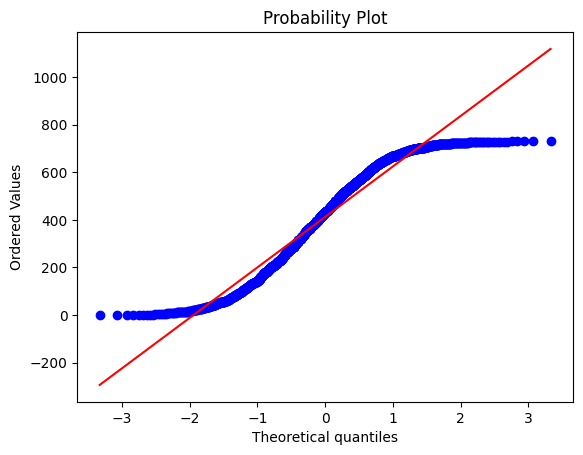

In [186]:
stats.probplot(takehome_users[takehome_users['adopted'] == 1]['days_since_creation'], dist="norm", plot=plt)

((array([-3.82036439, -3.59575425, -3.47246694, ...,  3.47246694,
          3.59575425,  3.82036439]),
  array([  0,   0,   0, ..., 729, 729, 729], dtype=int64)),
 (210.32859190011845, 410.85311929251174, 0.9712003789458882))

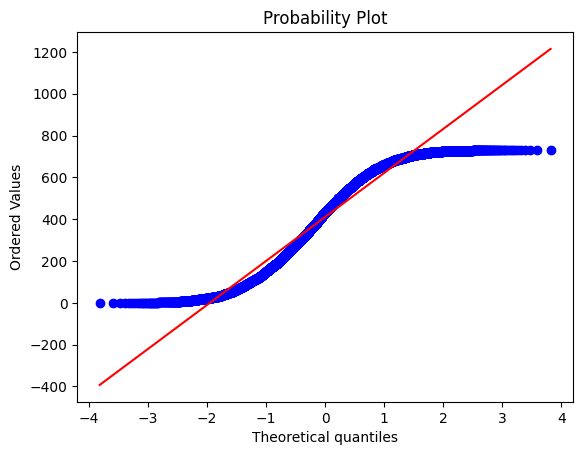

In [187]:
stats.probplot(takehome_users[takehome_users['adopted'] == 0]['days_since_creation'], dist="norm", plot=plt)

The Shapiro-Wilk tests result in a p-value less than 0, we can reject the null hypothesis that the data come from a normal distribution

In [188]:
stats.shapiro(takehome_users[takehome_users['adopted'] == 0]['days_since_creation'])

C:\Users\melis\Envs\ultimate-challenge\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9429655075073242, pvalue=0.0)

In [189]:
stats.shapiro(takehome_users[takehome_users['adopted'] == 1]['days_since_creation'])

ShapiroResult(statistic=0.9427279233932495, pvalue=2.158287149083048e-24)

Next, I will perform a Wilcoxon Rank Sum test to look at the correlation between 'days_since_creation' and whether the user is adopted or not. We find that the p-value is greater than .05, therefore, there is no statistical significant difference between the number of days since creating the account for adopted users and not adopted users.

In [191]:
stats.ranksums(takehome_users[takehome_users['adopted'] == 0]['days_since_creation'], takehome_users[takehome_users['adopted'] == 1]['days_since_creation'])

RanksumsResult(statistic=-0.27530838218195586, pvalue=0.7830793251630767)

### creation_source and marketing emails

PERSONAL_PROJECTS: invited to join another user's personal workspace
   * If they are working with others, they may be more likely to continue using the product
   
GUEST_INVITE: invited to an organization as a guest (limited permissions)
   * Do permission limit their use of the product?
   
ORG_INVITE: invited to an organization (as a full member)
   * If they are part of an organization, they may be more likely to continue using the product
   
SIGNUP: signed up via the website
   * Do they have their own personal projects they want to work on?
   
SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id)
   * does google authentication discourage the user from loging in?
   
opted_in_to_mailing_list: Have they opted to receive marketing emails?
   * If so, they may be more interested in the product
   
enabled_for_marketing_drip: Are they on regular marketing drip?
   * If so, they may be more interested in the product

In [27]:
takehome_users = pd.get_dummies(takehome_users, columns=['creation_source'])

adopted                               0     1
creation_source_PERSONAL_PROJECTS            
0                                  8565  1324
1                                  1838   273
The P-Value of the ChiSq Test is: 0.5995241970493331
adopted                          0     1
creation_source_GUEST_INVITE            
0                             8548  1289
1                             1855   308
The P-Value of the ChiSq Test is: 0.1696854733072167
adopted                        0     1
creation_source_ORG_INVITE            
0                           6704  1042
1                           3699   555
The P-Value of the ChiSq Test is: 0.550115333129558
adopted                    0     1
creation_source_SIGNUP            
0                       8606  1307
1                       1797   290
The P-Value of the ChiSq Test is: 0.4045666471433632
adopted                                0     1
creation_source_SIGNUP_GOOGLE_AUTH            
0                                   9189  1426
1   

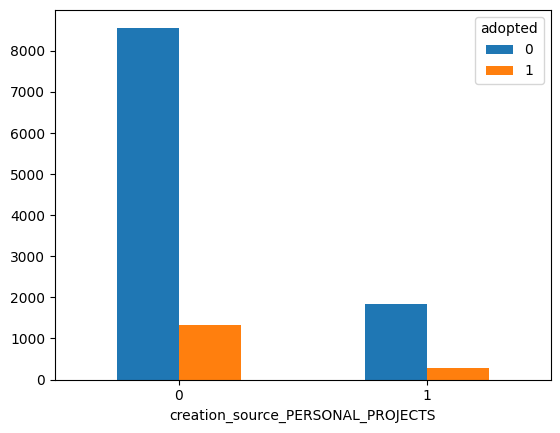

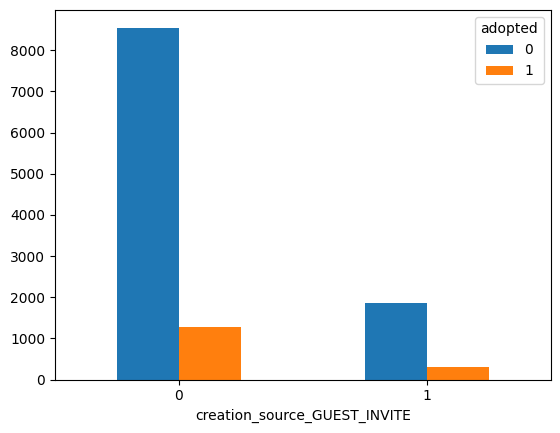

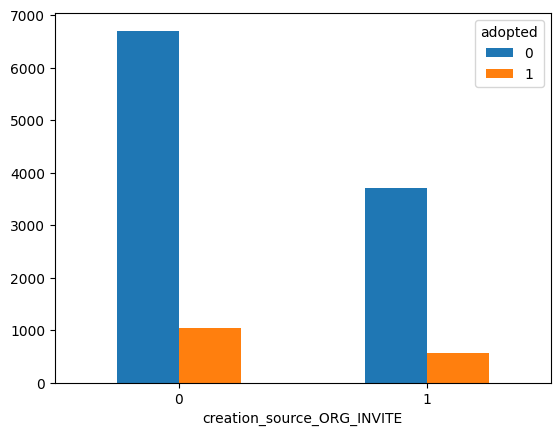

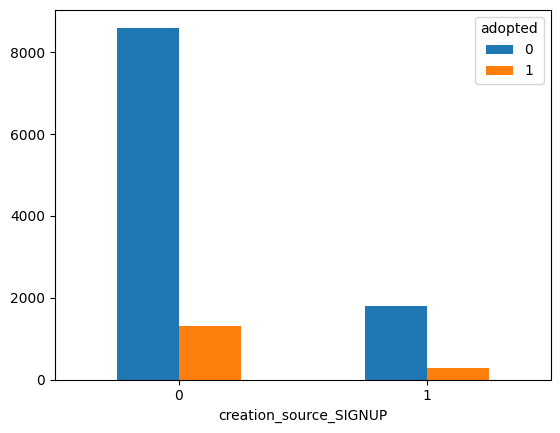

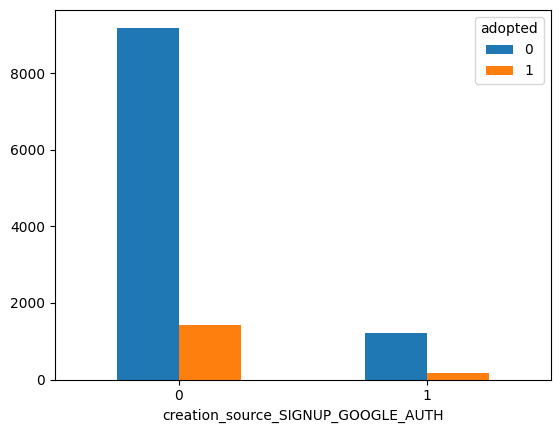

In [28]:
sources = ['PERSONAL_PROJECTS','GUEST_INVITE','ORG_INVITE','SIGNUP','SIGNUP_GOOGLE_AUTH']
# Cross tabulation between opted_in_to_mailing_list and enabled_for_marketing_drip
for source in sources:
    CrosstabResult=pd.crosstab(index=takehome_users['creation_source_%s' %(source)],
                           columns=takehome_users['adopted'])
    print(CrosstabResult)
 
    # Performing Chi-sq test
    ChiSqResult = chi2_contingency(CrosstabResult)
 
    # P-Value is the Probability of H0 being True
    # If P-Value > 0.05 then only we Accept the assumption(H0)
 
    print('The P-Value of the ChiSq Test is:', ChiSqResult[1])
    barplot = CrosstabResult.plot.bar(rot=0)

Are opted_in_to_mailing_list correlated to enabled_for_marketing_drip?

enabled_for_marketing_drip     0     1
opted_in_to_mailing_list              
0                           8556   450
1                           1652  1342
The P-Value of the ChiSq Test is: 0.0


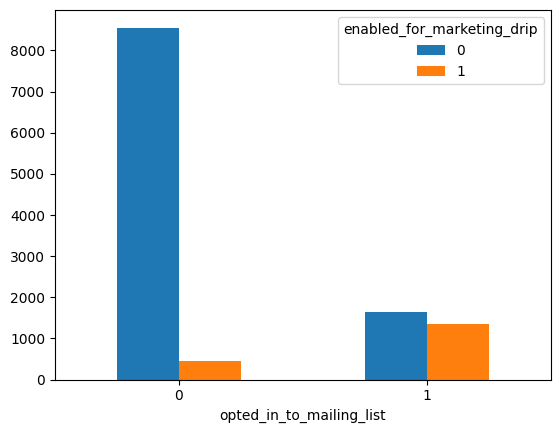

In [29]:
# Cross tabulation between opted_in_to_mailing_list and enabled_for_marketing_drip
CrosstabResult=pd.crosstab(index=takehome_users['opted_in_to_mailing_list'],
                           columns=takehome_users['enabled_for_marketing_drip'])
print(CrosstabResult)
 
# importing the required function
from scipy.stats import chi2_contingency
 
# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)
 
# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)
 
print('The P-Value of the ChiSq Test is:', ChiSqResult[1])
barplot = CrosstabResult.plot.bar(rot=0)

It looks like the two features are correlated according to the chi-squared test. If the user opted in to the mailing list, they are likely enabled for marketing drip. 

What about the correlation between the opted_in_to_mailing_list feature and whether the user was adopted?

adopted                      0     1
opted_in_to_mailing_list            
0                         7792  1214
1                         2611   383
The P-Value of the ChiSq Test is: 0.35309162393741833


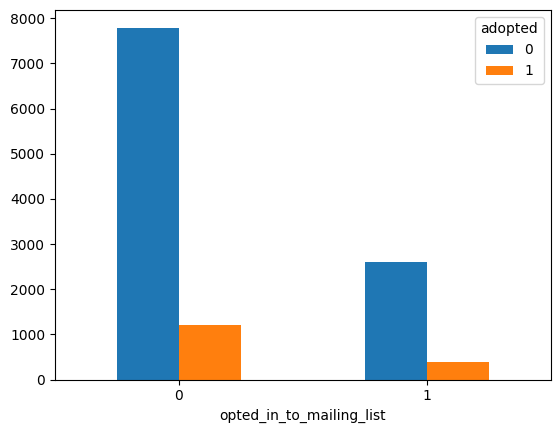

In [30]:
# Cross tabulation between opted_in_to_mailing_list and enabled_for_marketing_drip
CrosstabResult=pd.crosstab(index=takehome_users['opted_in_to_mailing_list'],
                           columns=takehome_users['adopted'])
print(CrosstabResult)
 
# importing the required function
from scipy.stats import chi2_contingency
 
# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)
 
# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)
 
print('The P-Value of the ChiSq Test is:', ChiSqResult[1])
barplot = CrosstabResult.plot.bar(rot=0)

It looks like the opted_in_to_mailing_list is not correlated to whether the user is an adopted user, according to the chi-squared test.

### last_session_creation_time

<AxesSubplot: >

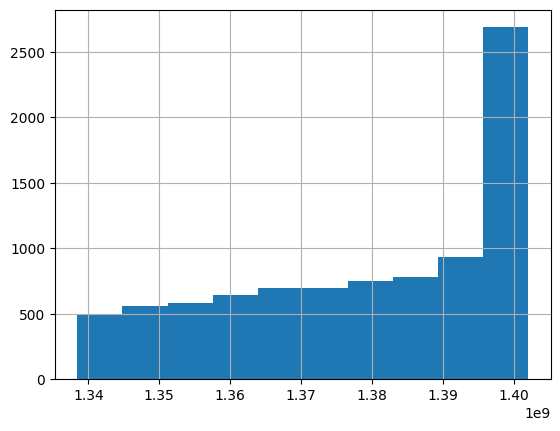

In [31]:
takehome_users['last_session_creation_time'].hist()

Normalize the last_session_creation_time

In [32]:
max_value = takehome_users['last_session_creation_time'].max()
min_value = takehome_users['last_session_creation_time'].min()
takehome_users['last_session_creation_time_norm'] = (takehome_users['last_session_creation_time'] - min_value) / (max_value - min_value)

<AxesSubplot: >

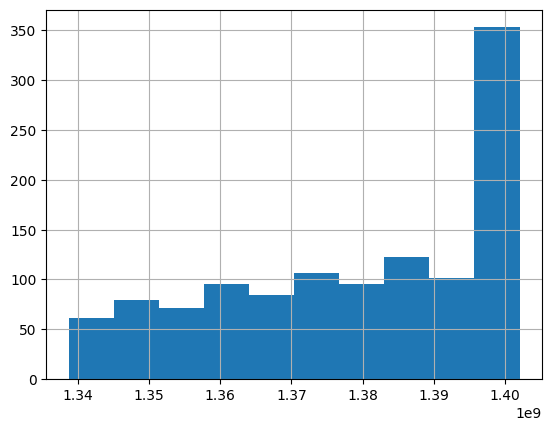

In [176]:
takehome_users[takehome_users['adopted'] == 1]['last_session_creation_time'].hist()

<AxesSubplot: >

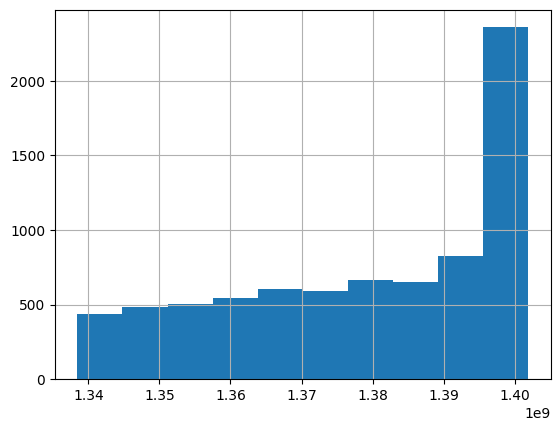

In [177]:
takehome_users[takehome_users['adopted'] == 0]['last_session_creation_time'].hist()

In [185]:
takehome_users[takehome_users['adopted'] == 0]['days_since_creation'].describe()

count    10403.000000
mean       410.853119
std        216.501242
min          0.000000
25%        230.000000
50%        431.000000
75%        606.000000
max        729.000000
Name: days_since_creation, dtype: float64

In [184]:
takehome_users[takehome_users['adopted'] == 1]['days_since_creation'].describe()

count    1597.000000
mean      412.175329
std       217.617572
min         0.000000
25%       228.000000
50%       432.000000
75%       610.000000
max       729.000000
Name: days_since_creation, dtype: float64

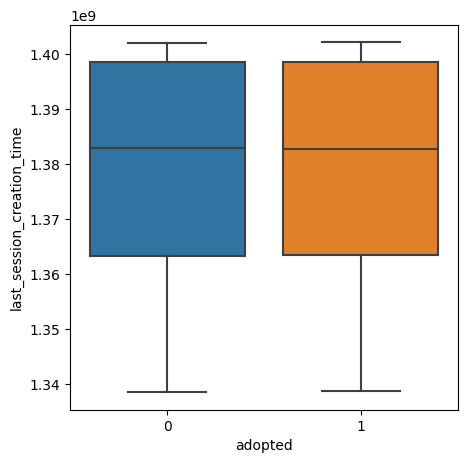

In [178]:
fig, ax = plt.subplots(1,1, figsize = (5,5))
sns.boxplot(data=takehome_users[['adopted','last_session_creation_time']].dropna(), 
            x="adopted", y="last_session_creation_time");

((array([-3.33018813, -3.07477781, -2.93285045, ...,  2.93285045,
          3.07477781,  3.33018813]),
  array([0.00364385, 0.0036583 , 0.00470463, ...,        nan,        nan,
                nan])),
 (nan, nan, nan))

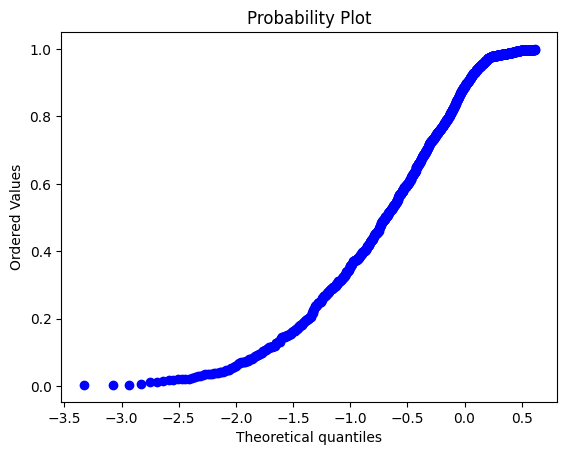

In [195]:
stats.probplot(takehome_users[takehome_users['adopted'] == 1]['last_session_creation_time_norm'], dist="norm", plot=plt)

((array([-3.82036439, -3.59575425, -3.47246694, ...,  3.47246694,
          3.59575425,  3.82036439]),
  array([0.        , 0.00050886, 0.00098319, ...,        nan,        nan,
                nan])),
 (nan, nan, nan))

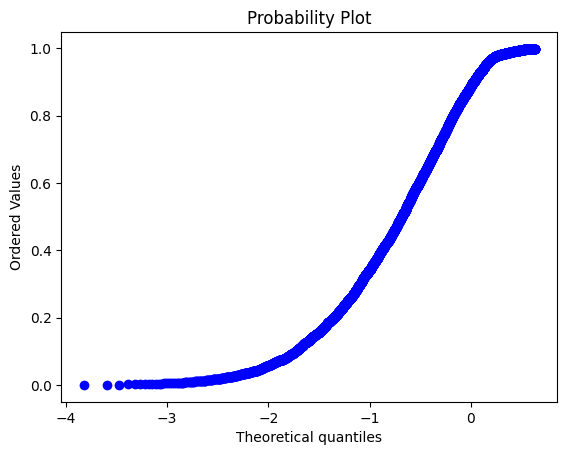

In [196]:
stats.probplot(takehome_users[takehome_users['adopted'] == 0]['last_session_creation_time_norm'], dist="norm", plot=plt)

In [201]:
stats.shapiro(takehome_users[takehome_users['adopted'] == 0]['last_session_creation_time_norm'])

ShapiroResult(statistic=nan, pvalue=1.0)

In [200]:
stats.shapiro(takehome_users[takehome_users['adopted'] == 1]['last_session_creation_time_norm'])

ShapiroResult(statistic=nan, pvalue=1.0)

In [179]:
stats.ttest_ind(takehome_users.dropna()['last_session_creation_time'], takehome_users.dropna()['adopted'])

Ttest_indResult(statistic=6633.3407078595465, pvalue=0.0)

In [193]:
stats.ranksums(takehome_users[takehome_users['adopted'] == 0]['last_session_creation_time_norm'], takehome_users[takehome_users['adopted'] == 1]['last_session_creation_time_norm'])

RanksumsResult(statistic=nan, pvalue=nan)

There is no difference in the last login time of the adopted and not adopted users

In [37]:
takehome_users[takehome_users['adopted'] == 0]['last_session_creation_time_norm'].describe()

count    7656.000000
mean        0.642000
std         0.307572
min         0.000000
25%         0.388783
50%         0.699056
75%         0.942898
max         0.997791
Name: last_session_creation_time_norm, dtype: float64

In [38]:
takehome_users[takehome_users['adopted'] == 1]['last_session_creation_time_norm'].describe()

count    1167.000000
mean        0.640394
std         0.303533
min         0.003644
25%         0.391083
50%         0.693852
75%         0.943549
max         1.000000
Name: last_session_creation_time_norm, dtype: float64

### Conclusions from exploratory data analysis

In this section I investigated the correlation between features in the dataset, and whether a user can be considered "adopted" or not. The features that I took into consideration are the following:

* creation_source:   how  their  account  was  created.
  * PERSONAL_PROJECTS:  invited  to  join  another  user's personal  workspace
  * GUEST_INVITE:  invited  to  an  organization  as  a  guest (limited  permissions)
  * ORG_INVITE:  invited  to  an  organization  (as  a  full  member)
  * SIGNUP:  signed  up  via  the  website
  * SIGNUP_GOOGLE_AUTH:  signed  up  using  Google Authentication  (using  a  Google  email  account  for  their  login id)
* opted_in_to_mailing_list:  whether  they  have  opted  into  receiving marketing  emails
* last_session_creation_time:   unix  timestamp  of  last  login

* new features:
  * creation_time_season: season of the year when they created their account
  * days_since_creation: number of days since the time they created their account
  * invited_by_user_adopted:   whether the user that invited that invited them is an adopted user or not
  
I applied the chi squared statistic test to look at the correlation between the categorical variables and whether a user is considered "adopted" or not. However, all these tests resulted in a p-value greater than 0.05, indicating no correlation. I also applied the t statistic test and the Wilcoxon rank-sum statistical test between the numerical features last_session_creation_time and the days_since_creation. 

### Modeling

After looking at possible correlations between the categorical and numerical features and whether the user was adopted or not, I will apply logistic regression and a regression tree to identify other possible hints that can tell us what can lead to an adopted user.

First, I will prepare the dataset once again so all the feature engineering (i.e. one hot encoding and imputing missing values) can occur in a pipeline to prevent data leakage.

In [166]:
#load dataset and identify adopted and not adopted users
data = pd.read_csv("takehome_users.csv", encoding='latin-1')
data.rename(columns={'object_id':"user_id"}, inplace = True)
data['adopted'] = 0
for i, row in data.iterrows():
    if row['user_id'] in active_users:
        data.loc[data['user_id'] == i,'adopted'] = 1

In [51]:
#Add a column to specify whether the adopted user was invited by a user that is thought of as "adopted"
data.invited_by_user_id = data.invited_by_user_id.fillna(-1)
data.invited_by_user_id = data.invited_by_user_id.astype('int')
data['invited_by_user_adopted'] = 0
for i, row in data.iterrows():
    if row['invited_by_user_id'] in active_users:
        data.loc[data['invited_by_user_id'] == i,'invited_by_user_adopted'] = 1

In [54]:
#add a column for the season in the year when the users created the account/accessed the product, and a column
#for the number of days that have passed since creation
data['creation_time'] = pd.to_datetime(data['creation_time'])
data['creation_time_dayofyear'] = data.creation_time.dt.dayofyear
data['creation_time_season'] = data['creation_time_dayofyear'].apply(add_season)

data['days_since_creation'] = data['creation_time'] - data.creation_time.min()
data['days_since_creation'] = data['days_since_creation'].dt.days

In [57]:
#keep the columns we want to keep for modeling
data = data[['creation_source','last_session_creation_time','opted_in_to_mailing_list','invited_by_user_adopted',
      'creation_time_season', 'days_since_creation', 'adopted']]
data

,creation_source,last_session_creation_time,opted_in_to_mailing_list,invited_by_user_adopted,creation_time_season,days_since_creation,adopted
0,GUEST_INVITE,1.398139e+09,1,0,spring,691,1
1,ORG_INVITE,1.396238e+09,0,0,fall,533,0
2,ORG_INVITE,1.363735e+09,0,0,winter,292,0
3,GUEST_INVITE,1.369210e+09,0,0,spring,355,0
4,GUEST_INVITE,1.358850e+09,0,0,winter,231,0
...,...,...,...,...,...,...,...
11995,ORG_INVITE,1.378448e+09,0,0,summer,463,0
11996,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,winter,224,0
11997,GUEST_INVITE,1.398603e+09,1,0,spring,696,0
11998,PERSONAL_PROJECTS,1.338638e+09,0,0,spring,0,0


In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   creation_source             12000 non-null  object 
 1   last_session_creation_time  8823 non-null   float64
 2   opted_in_to_mailing_list    12000 non-null  int64  
 3   invited_by_user_adopted     12000 non-null  int64  
 4   creation_time_season        12000 non-null  object 
 5   days_since_creation         12000 non-null  int64  
 6   adopted                     12000 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 656.4+ KB


Define X and y. Prepare pipeline for transforming the columns.

In [60]:
y = data['adopted']
X = data.drop(['adopted'], axis = 1)

In [135]:
numeric_features = ['last_session_creation_time', 'days_since_creation']
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])


categorical_features = ["creation_source", "creation_time_season"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

### Logistic Regression Modeling

After applying the model, we achieve an accuracy of 0.855.

In [138]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.855


Apply a grid search by imputing the missing values with the mean or median for the numerical features, and varying the C parameter of the algorithm. Our best accuracy is still 0.855

In [139]:
param_grid = {
    "preprocessor__num__imputer__strategy": ["mean", "median"],
    "classifier__C": [0.1, 1.0, 10, 100],
}

grid_search = GridSearchCV(clf, param_grid, cv=10)
grid_search

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['last_session_creation_time',
                                                                          'days_since_creation']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['creation_source',
                                                                          'creation_time_season'])])),
                                       ('classifier', LogisticRegression())]),
             param_grid={'classifier__C': [0.1, 1.0, 10, 100],
                         'preprocessor__num__imputer__strategy': ['mean',
                                                                  'median']})

In [140]:
grid_search.fit(X_train, y_train)

print("Best params:")
print(grid_search.best_params_)

Best params:
{'classifier__C': 0.1, 'preprocessor__num__imputer__strategy': 'mean'}


In [142]:
print(
    (
        "best logistic regression from grid search: %.3f"
        % grid_search.score(X_test, y_test)
    )
)

best logistic regression from grid search: 0.855


C:\Users\melis\Envs\ultimate-challenge\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\melis\Envs\ultimate-challenge\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\melis\Envs\ultimate-challenge\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.85      1.00      0.92      2052
           1       0.00      0.00      0.00       348

    accuracy                           0.85      2400
   macro avg       0.43      0.50      0.46      2400
weighted avg       0.73      0.85      0.79      2400



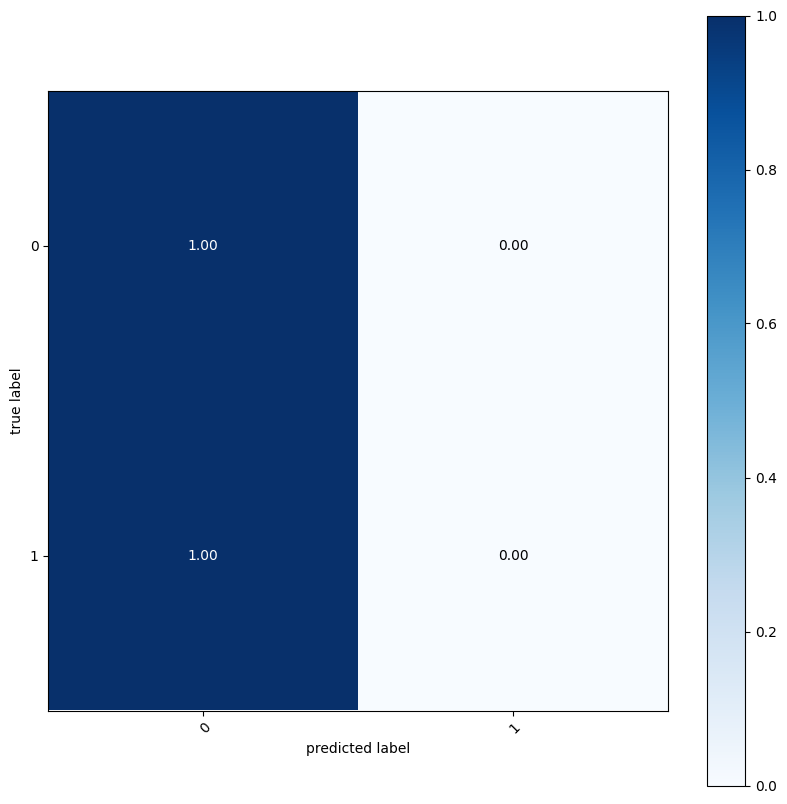

In [68]:
predicted_LR = grid_search.predict(X_test)
print(classification_report(y_test, predicted_LR))

multiclass = confusion_matrix(y_test, predicted_LR)

class_names = grid_search.classes_

fig, ax = plot_confusion_matrix(conf_mat=multiclass,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,
                                class_names=class_names,
                                figsize = (10,10))
plt.show()

### Classification Tree

We still obtain an accuracy of 0.855 with a classification tree.

In [143]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", tree.DecisionTreeClassifier(criterion="entropy",max_depth = 3, random_state=1234))]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.855


Apply a grid search and hypertune the model by changing the imputing strategy, the depth of the tree, and the criterion for the quality of the split

In [144]:
param_grid = {
    "preprocessor__num__imputer__strategy": ["mean", "median"],
    "classifier__criterion": ["entropy", "gini"],
    "classifier__max_depth": [None, 3]
}

grid_search = GridSearchCV(clf, param_grid, cv=10)
grid_search

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['last_session_creation_time',
                                                                          'days_since_creation']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['creation_source',
                                                                          'creation_time_season'])])),
                                       ('classifier',
                                        DecisionTreeClassifier(criterion='entropy',
                                                               max_depth=3,
                                                               random_state=1234))]),
             param_grid={'classifier__criterion': ['entropy', 'gini'],
                         'classifier__max_depth': [None, 3],
                         'preprocessor__num__imputer__strategy': ['mean',
                                                                  'median']})

In [145]:
grid_search.fit(X_train, y_train)

print("Best params:")
print(grid_search.best_params_)

Best params:
{'classifier__criterion': 'entropy', 'classifier__max_depth': 3, 'preprocessor__num__imputer__strategy': 'mean'}


In [146]:
grid_search.best_estimator_.named_steps['preprocessor']

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['last_session_creation_time',
                                  'days_since_creation']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['creation_source', 'creation_time_season'])])

In [167]:
print(
    (
        "best classification tree from grid search: %.3f"
        % grid_search.score(X_train, y_train)
    )
)

best classification tree from grid search: 0.870


              precision    recall  f1-score   support

           0       0.87      1.00      0.93      8351
           1       0.86      0.00      0.01      1249

    accuracy                           0.87      9600
   macro avg       0.86      0.50      0.47      9600
weighted avg       0.87      0.87      0.81      9600



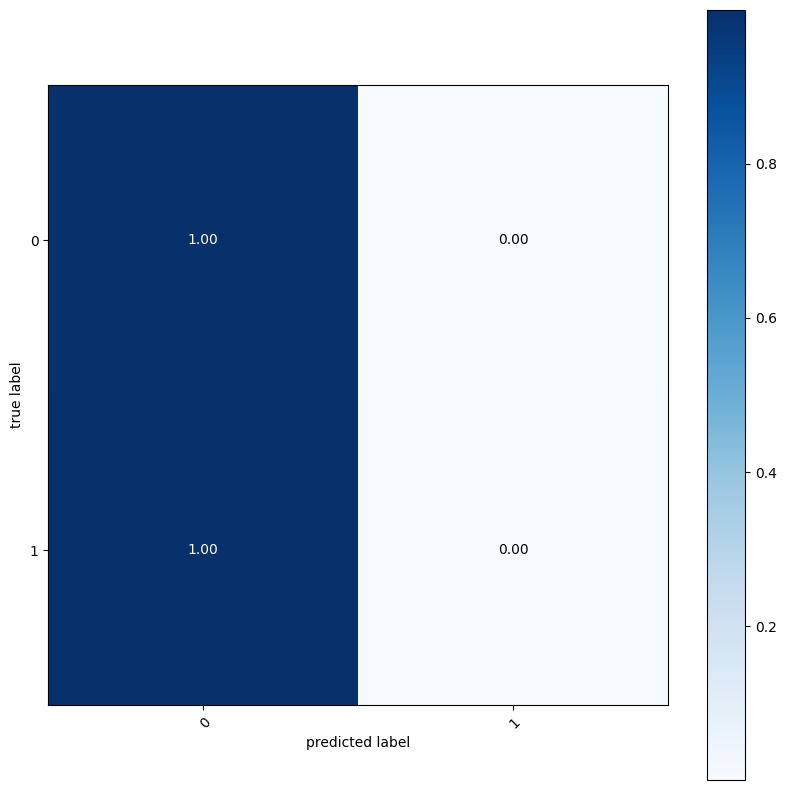

In [170]:
predicted_DT = grid_search.predict(X_train)
print(classification_report(y_train, predicted_DT))

multiclass = confusion_matrix(y_train, predicted_DT)

class_names = grid_search.classes_

fig, ax = plot_confusion_matrix(conf_mat=multiclass,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,
                                class_names=class_names,
                                figsize = (10,10))
plt.show()

C:\Users\melis\Envs\ultimate-challenge\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\melis\Envs\ultimate-challenge\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\melis\Envs\ultimate-challenge\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.85      1.00      0.92      2052
           1       0.00      0.00      0.00       348

    accuracy                           0.85      2400
   macro avg       0.43      0.50      0.46      2400
weighted avg       0.73      0.85      0.79      2400



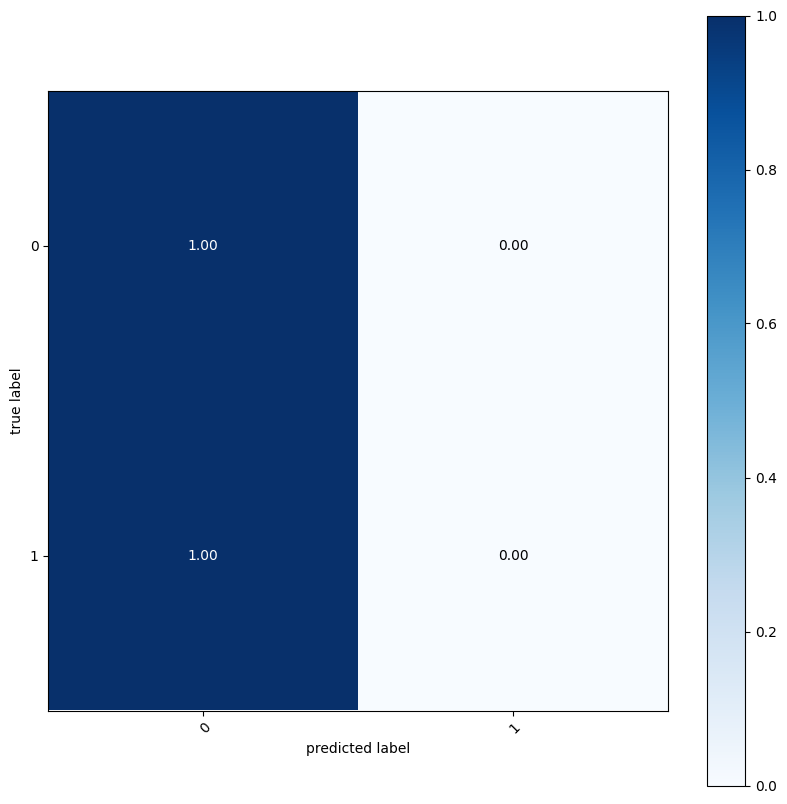

In [83]:
predicted_DT = grid_search.predict(X_test)
print(classification_report(y_test, predicted_DT))

multiclass = confusion_matrix(y_test, predicted_DT)

class_names = grid_search.classes_

fig, ax = plot_confusion_matrix(conf_mat=multiclass,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,
                                class_names=class_names,
                                figsize = (10,10))
plt.show()

In [149]:
features = list(X_train.columns)
# Extracting the importances by sklearn 
importances_sk = grid_search.best_estimator_.named_steps.classifier.feature_importances_

# Creating a dataframe with the feature importance by sklearn
feature_importance_sk = {}
for i, feature in enumerate(features):
    feature_importance_sk[feature] = round(importances_sk[i], 3)

print(f"Feature importance by sklearn: {feature_importance_sk}")

Feature importance by sklearn: {'creation_source': 0.74, 'last_session_creation_time': 0.142, 'opted_in_to_mailing_list': 0.0, 'invited_by_user_adopted': 0.118, 'creation_time_season': 0.0, 'days_since_creation': 0.0}


In [150]:
grid_search.best_estimator_.named_steps.classifier.feature_importances_

array([0.7401847 , 0.14192319, 0.        , 0.11789211, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [90]:
X_train.columns

Index(['creation_source', 'last_session_creation_time',
       'opted_in_to_mailing_list', 'invited_by_user_adopted',
       'creation_time_season', 'days_since_creation'],
      dtype='object')

In the plotted decision tree below, we find that the model does a poor job in classifying the adopted users. only 16 were classified under "adopted". 

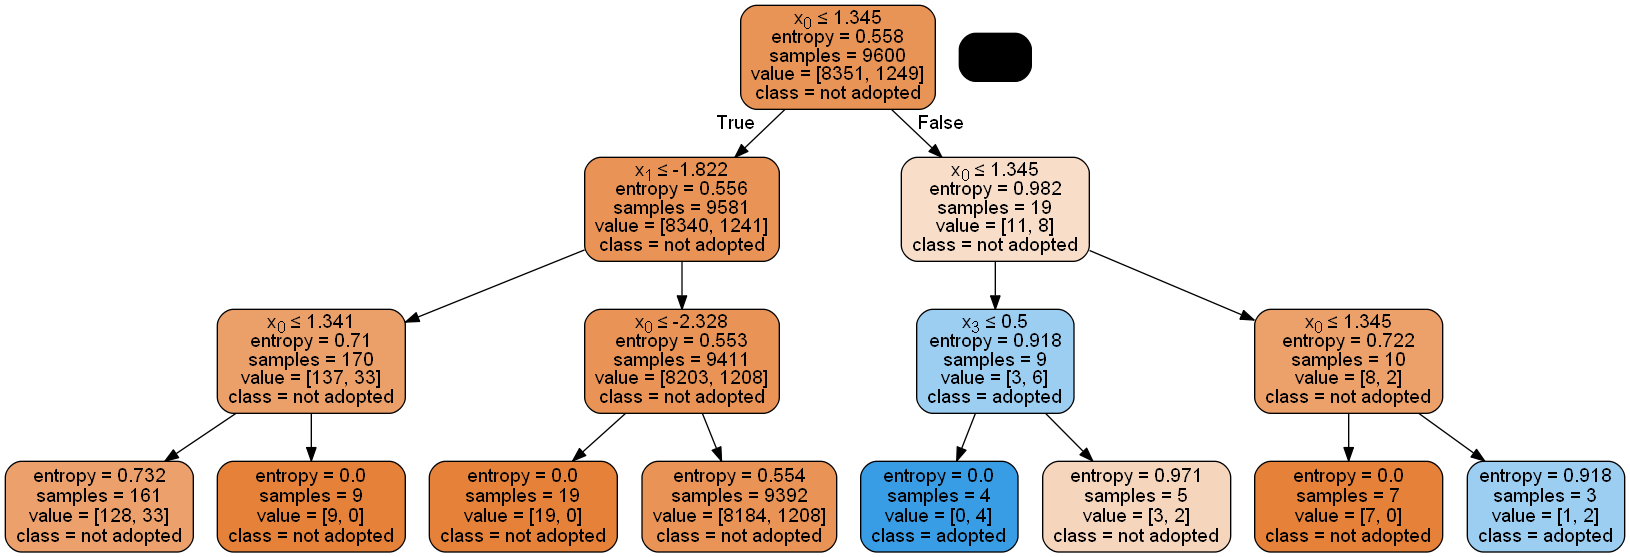

In [111]:
# Now we want to visualize the tree
dot_data = StringIO()

# We can do so with export_graphviz
tree.export_graphviz(grid_search.best_estimator_.named_steps.classifier, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = None, class_names = ['not adopted','adopted']) 

# Alternatively for class_names use entr_model.classes_
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### Conclusions from Modeling

The logistic regression model is predicting all users in the testing and training datasets to be "not adopted" users. The decision tree model is predicting all users in the testing dataset to be "not adopted", and 7 from the training dataset to be "adopted" users. Both models have a poor performance considering that in the training dataset there are 1249 "adopted" users, and in the testing dataset there are 348 "adopted users". Therefore, our metric of accuracy is poor. While it correctly identifies the majority of the users as "not adopted", it incorrectly assigns most "adopted" users under "not adopted". It seems like more feature engineering or more data needs to be gathered in order to correctly classify the "adopted" users. 